In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torchvision.datasets
from torchsummary import summary 

#### Data and transforms

In [2]:
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomRotation(degrees=20),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Normalize(0.5, 0.5, inplace=True),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5, inplace=True),
    ]
)

In [3]:
CIFAR100 = torchvision.datasets.CIFAR100(root='./', download=True)
len(CIFAR100)

Files already downloaded and verified


50000

In [4]:
data_classes = CIFAR100.classes

In [5]:
idx_to_class = {k : v for k, v in zip(np.arange(0, 100), data_classes)}

In [6]:
train_data, test_data = torch.utils.data.random_split(CIFAR100, [0.7, 0.3])

In [7]:
len(train_data), len(test_data)

(35000, 15000)

In [8]:
train_data.dataset.transform = train_transform
test_data.dataset.transforms = test_transform

In [9]:
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=1000, pin_memory=True, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=1000, pin_memory=True, shuffle=True
)

In [10]:
imgs, labels = next(iter(train_loader))

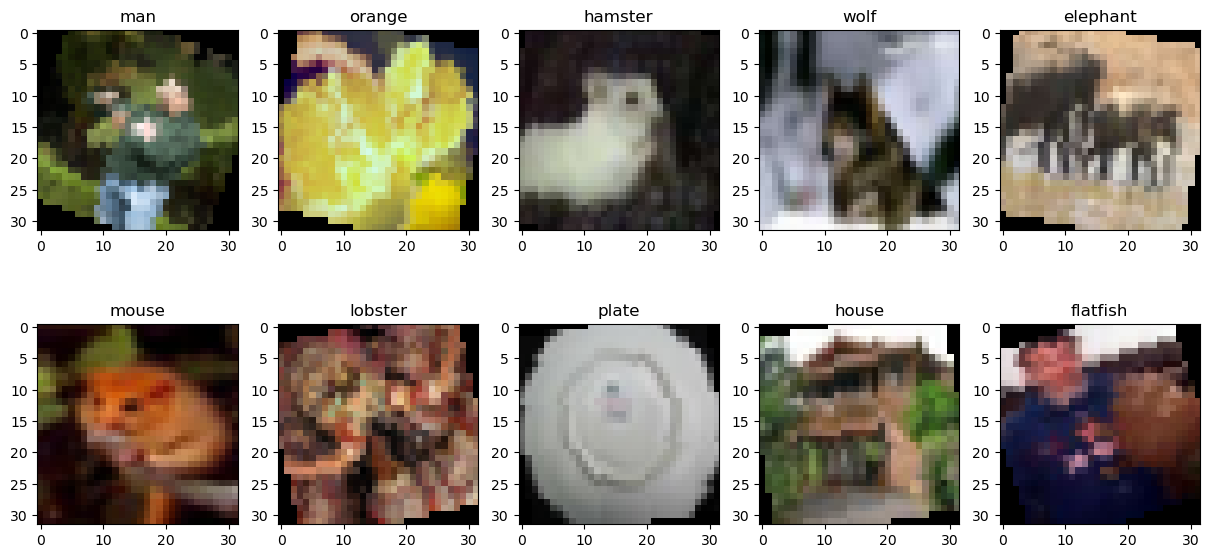

In [22]:
fig, ax = plt.subplots(2, 5, figsize=(15, 7))
for i in range(10):
    ax[i // 5][i % 5].imshow((imgs[i] * 0.5 + 0.5) .to(torch.float32).permute((1, 2, 0)))
    ax[i // 5][i % 5].title.set_text(idx_to_class[labels[i].item()])
plt.show();

#### Let's start with ResNet

In [11]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [24]:
class ResBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride, padding=1),
            nn.BatchNorm2d(out_channels),
            self.relu,
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, padding=1),
            nn.BatchNorm2d(out_channels),
        )
    

    def forward(self, x):
        identity = x.clone()
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            identity = self.downsample(identity)
        out += identity
        out = self.relu(out)
        return out

In [25]:
class ResNet(nn.Module):

    def __init__(self, resblock, layers, out_classes):

        super().__init__()
        self.channesl = 32
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 7, padding=3, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
        self.mp = nn.MaxPool2d(2, 2)

        self.layer1 = self.make_layer(resblock, 32, layers[0], 1)
        self.layer2 = self.make_layer(resblock, 64, layers[1], 2)
        self.layer3 = self.make_layer(resblock, 128, layers[2], 2)
        self.layer4 = self.make_layer(resblock, 256, layers[3], 2)
        self.pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.fc = nn.Linear(256, out_classes)

    def make_layer(self, block, channels, num_blocks, stride=1):
        downsample = None
        if stride != 1 or self.channesl != channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.channesl, channels, 1, stride), nn.BatchNorm2d(channels)
            )

        layers = []
        for i in range(num_blocks):
            if i == 0:
                layers.append(block(self.channesl, channels, stride, downsample))
                self.channesl = channels
            else:
                layers.append(block(self.channesl, channels))

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv1(x)
        x = self.mp(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [12]:
def train_func(tr_l, ts_l, loss_fn, acc_fn, device, epochs=100, lr = 1e-4, model_class = None, model = None):
    if model_class == None and model == None:
        raise ValueError("Model empty")
    train_loss_hist = []
    test_loss_hist = []
    test_acc_hist = []

    

    if model == None:
        model = model_class().half().to(device)
    

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad=True, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.7)


    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = 0

        for X, y in tr_l:
            optimizer.zero_grad()

            X, y = X.to(device), y.type(torch.LongTensor).to(device)
            preds = model(X)
            
            loss = loss_fn(preds, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        
        scheduler.step()
        train_loss /= len(tr_l)
        train_loss_hist.append(train_loss)


        model.eval()
        test_loss = 0
        test_acc = 0

        

        with torch.no_grad():
            for X, y in ts_l:
                X, y = X.to(device), y.type(torch.LongTensor).to(device)
                preds = model(X)
                test_loss += loss_fn(preds, y).item()
                test_acc += acc_fn(y, torch.argmax(preds, dim=1)).item()

        

        test_loss /= len(ts_l)
        test_acc /= len(ts_l)
        test_loss_hist.append(test_loss)
        test_acc_hist.append(test_acc)

        print(
            f"Epoch: {epoch}\ttrain loss: {loss}\ttest loss:{test_loss}\ttest acc:{test_acc}"
        )
        
    return (model, train_loss_hist, test_loss_hist, test_acc_hist)

In [55]:
model = ResNet(ResBlock, [2, 2, 2, 2], 100).to(device)

In [56]:
summary(ResNet(ResBlock, [2, 2, 2, 2], 100), input_size=(3, 32, 32), batch_size=1000, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [1000, 32, 16, 16]           4,736
       BatchNorm2d-2         [1000, 32, 16, 16]              64
              ReLU-3         [1000, 32, 16, 16]               0
         MaxPool2d-4           [1000, 32, 8, 8]               0
            Conv2d-5           [1000, 32, 8, 8]           9,248
       BatchNorm2d-6           [1000, 32, 8, 8]              64
              ReLU-7           [1000, 32, 8, 8]               0
              ReLU-8           [1000, 32, 8, 8]               0
            Conv2d-9           [1000, 32, 8, 8]           9,248
      BatchNorm2d-10           [1000, 32, 8, 8]              64
             ReLU-11           [1000, 32, 8, 8]               0
             ReLU-12           [1000, 32, 8, 8]               0
         ResBlock-13           [1000, 32, 8, 8]               0
           Conv2d-14           [1000, 3

In [13]:
loss_fn = torch.nn.CrossEntropyLoss()

In [14]:
def acc_fn(y_true, y_preds):
    if y_true.shape != y_preds.shape:
        raise ValueError("Different shapes y_true and y_pred")

    return torch.sum(y_true == y_preds) / len(y_true)

In [15]:
import gc

gc.collect()

torch.mps.empty_cache()

In [60]:
tr_model, tr_loss_hist, ts_loss_hist, ts_acc_hist = train_func(train_loader, test_loader, loss_fn, acc_fn, device, 70, 3e-3, model = model)

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch: 0	train loss: 3.5424976348876953	test loss:3.8050146738688153	test acc:0.11686666756868362
Epoch: 1	train loss: 3.287302017211914	test loss:3.5596118450164793	test acc:0.15253333548704784
Epoch: 2	train loss: 3.07271671295166	test loss:3.3213178793589275	test acc:0.19726666609446208
Epoch: 3	train loss: 2.8516976833343506	test loss:3.1445757865905763	test acc:0.22906666696071626
Epoch: 4	train loss: 2.7597944736480713	test loss:2.9991936365763348	test acc:0.248799999554952
Epoch: 5	train loss: 2.6895551681518555	test loss:2.9270270983378093	test acc:0.2663999984661738
Epoch: 6	train loss: 2.5644619464874268	test loss:2.8486448923746743	test acc:0.28453333377838136
Epoch: 7	train loss: 2.497436046600342	test loss:2.8979650497436524	test acc:0.27493333419164023
Epoch: 8	train loss: 2.4475417137145996	test loss:2.8047593434651694	test acc:0.2912000040213267
Epoch: 9	train loss: 2.332411766052246	test loss:2.706875944137573	test acc:0.31639999349912007
Epoch: 10	train loss: 2.290157

In [16]:
def plot_train_func(train_loss_hist, test_loss_hist, test_acc_hist):
    d = {0: train_loss_hist, 1: test_loss_hist, 2: test_acc_hist}
    names = {0: "Train loss", 1: "Test loss", 2: "Test accuracy"}
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    for i in range(3):
        ax[i].plot(d[i])
        ax[i].grid()
        ax[i].set_title(names[i])
    plt.show()

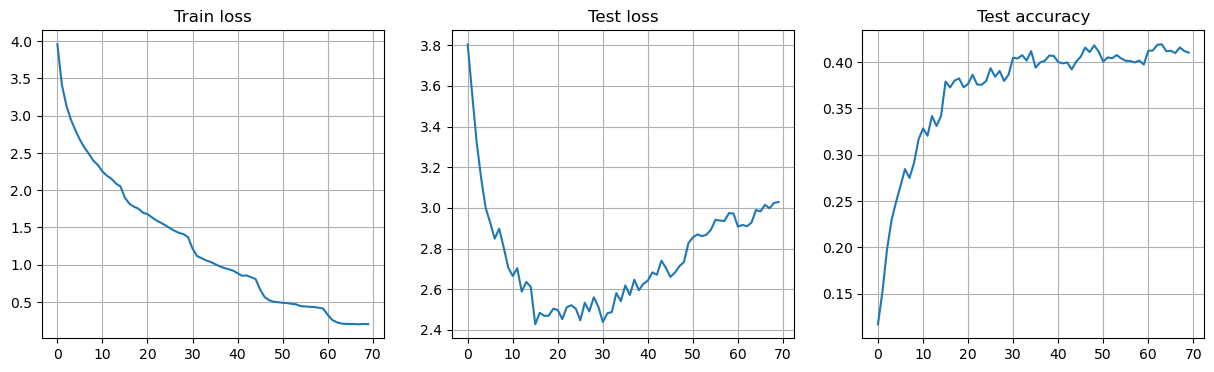

In [ ]:
plot_train_func(tr_loss_hist, ts_loss_hist, ts_acc_hist)

#### Let's make Inception Net

In [63]:
class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c, k_size, stride, padding):
        super(ConvBlock, self).__init__()
        self.Conv = nn.Conv2d(in_c, out_c, k_size, stride, padding)
        self.Bn = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.Conv(x)
        x = self.Bn(x)
        x = self.relu(x)
        return x

In [64]:
class InceptionBlock(nn.Module):
    def __init__(self, in_c, num_x1, num_x3, num_x5, num_x3red, num_x5red, pooling):
        super(InceptionBlock, self).__init__()

        self.Blocks = nn.ModuleList(
            [
                nn.Sequential(ConvBlock(in_c, num_x1, 1, 1, 0)),
                
                nn.Sequential(
                    ConvBlock(in_c, num_x3red, 1, 1, 0),
                    ConvBlock(num_x3red, num_x3, 3, 1, 1),
                ),
                
                nn.Sequential(
                    ConvBlock(in_c, num_x5red, 1, 1, 0),
                    ConvBlock(num_x5red, num_x5, 5, 1, 2),
                ),
                
                nn.Sequential(nn.MaxPool2d(3, 1, 1), ConvBlock(in_c, pooling, 1, 1, 0)),
            ]
        )

    def forward(self, x):
        res = []
        for block in self.Blocks:
            res.append(block(x))
        return torch.cat(res, dim = 1)

In [65]:
class OutClassifier(nn.Module):
    def __init__(self, in_c, out_classes):
        super(OutClassifier, self).__init__()
        self.AdaptiveAVG = nn.AdaptiveAvgPool2d(output_size=4)
        self.Conv = nn.Conv2d(in_c, 128, 1, 1, 0)
        self.relu = nn.ReLU(inplace=True)
        self.FC1 = nn.Linear(2048, 1024)
        self.Drop = nn.Dropout(0.7)
        self.FC2 = nn.Linear(1024, out_classes)
    

    def forward(self, x):
        x = self.AdaptiveAVG(x)
        x = self.Conv(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)
        x = self.FC1(x)
        x = self.Drop(x)
        x = self.FC2(x)
        return x

In [66]:
class InceptionNetV1(nn.Module):
    def __init__(self, out_classes):
        super(InceptionNetV1, self).__init__()
        self.Conv1 = ConvBlock(in_c=3, out_c=32, k_size=7, stride=2, padding=3)
        self.Maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=True)
        self.Conv2_1 = ConvBlock(32, 32, 1, 1, 0)
        self.Conv2_2 = ConvBlock(32, 64, 3, 1, 1)
        self.Maxpool2 = nn.MaxPool2d(3, 2, 0, ceil_mode=True)
        self.Inception3_1 = InceptionBlock(
            in_c=64,
            num_x1=16, #
            num_x3=32, #
            num_x5=8, #
            num_x3red=16,
            num_x5red=4,
            pooling=8, #
        )

        self.Inception3_2 = InceptionBlock(
            in_c=64,
            num_x1=32,
            num_x3=64,
            num_x5=16,
            num_x3red=32,
            num_x5red=8,
            pooling=16,
        )

        self.Maxpool3 = nn.MaxPool2d(3, 2, 0, ceil_mode=True)

        self.Inception4_1 = InceptionBlock(
            in_c=128,
            num_x1=32,
            num_x3=128,
            num_x5=16,
            num_x3red=64,
            num_x5red=8,
            pooling=16,
        )

        self.Inception4_2 = InceptionBlock(
            in_c=192,
            num_x1=64,
            num_x3=128,
            num_x5=32,
            num_x3red=96,
            num_x5red=16,
            pooling=32,
        )

        self.Inception4_3 = InceptionBlock(
            in_c=256,
            num_x1=64,
            num_x3=128,
            num_x5=32,
            num_x3red=96,
            num_x5red=16,
            pooling=32,
        )

        self.Inception4_4 = InceptionBlock(
            in_c=256,
            num_x1=128,
            num_x3=192,
            num_x5=32,
            num_x3red=96,
            num_x5red=16,
            pooling=32,
        )

        self.Inception4_5 = InceptionBlock(
            in_c=384,
            num_x1=128,
            num_x3=256,
            num_x5=64,
            num_x3red=128,
            num_x5red=32,
            pooling=64,
        )

        self.Maxpool4 = nn.MaxPool2d(3, 2, ceil_mode=True)

        self.Inception5_1 = InceptionBlock(
            in_c=512,
            num_x1=128,
            num_x3=256,
            num_x5=64,
            num_x3red=128,
            num_x5red=32,
            pooling=64,
        )

        self.Inception5_2 = InceptionBlock(
            in_c=512,
            num_x1=256,
            num_x3=512,
            num_x5=128,
            num_x3red=128,
            num_x5red=32,
            pooling=128,
        )

        self.AvgPool = nn.AdaptiveAvgPool2d(output_size=1)

        self.Drop = nn.Dropout(0.4)
        self.FC = nn.Linear(1024, out_classes)

        self.Exit1 = OutClassifier(192, out_classes)
        self.Exit2 = OutClassifier(384, out_classes)

    def forward(self, x):
        x = self.Conv1(x)
        x = self.Maxpool1(x)
        x = self.Conv2_1(x)
        x = self.Conv2_2(x)
        x = self.Maxpool2(x)
        x = self.Inception3_1(x)
        x = self.Inception3_2(x)
        x = self.Maxpool3(x)
        x = self.Inception4_1(x)
        out1 = self.Exit1(x)
        x = self.Inception4_2(x)
        x = self.Inception4_3(x)
        x = self.Inception4_4(x)
        out2 = self.Exit2(x)
        x = self.Inception4_5(x)
        x = self.Maxpool4(x)
        x = self.Inception5_1(x)
        x = self.Inception5_2(x)
        x = self.AvgPool(x)
        x = x.view(x.size(0), - 1)
        x = self.Drop(x)
        x = self.FC(x)

        return x, out1, out2

In [67]:
model = InceptionNetV1(100).to(device)

In [70]:
summary(InceptionNetV1(100), input_size=(3, 32, 32), batch_size=1000, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [1000, 32, 16, 16]           4,736
       BatchNorm2d-2         [1000, 32, 16, 16]              64
              ReLU-3         [1000, 32, 16, 16]               0
         ConvBlock-4         [1000, 32, 16, 16]               0
         MaxPool2d-5           [1000, 32, 9, 9]               0
            Conv2d-6           [1000, 32, 9, 9]           1,056
       BatchNorm2d-7           [1000, 32, 9, 9]              64
              ReLU-8           [1000, 32, 9, 9]               0
         ConvBlock-9           [1000, 32, 9, 9]               0
           Conv2d-10           [1000, 64, 9, 9]          18,496
      BatchNorm2d-11           [1000, 64, 9, 9]             128
             ReLU-12           [1000, 64, 9, 9]               0
        ConvBlock-13           [1000, 64, 9, 9]               0
        MaxPool2d-14           [1000, 6

In [ ]:
def train_func(tr_l, ts_l, loss_fn, acc_fn, device, epochs=100, lr = 1e-4, model_class = None, model = None):
    if model_class == None and model == None:
        raise ValueError("Model empty")
    train_loss_hist = []
    test_loss_hist = []
    test_acc_hist = []

    

    if model == None:
        model = model_class().half().to(device)
    

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad=True, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)


    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = 0

        for X, y in tr_l:
            optimizer.zero_grad()

            X, y = X.to(device), y.type(torch.LongTensor).to(device)
            preds, ou1, ou2 = model(X)
            
            loss = loss_fn(preds, y) + 0.3 * loss_fn(ou1, y) + 0.3 * loss_fn(ou2, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        
        scheduler.step()
        train_loss /= len(tr_l)
        train_loss_hist.append(train_loss)


        model.eval()
        test_loss = 0
        test_acc = 0

        

        with torch.no_grad():
            for X, y in ts_l:
                X, y = X.to(device), y.type(torch.LongTensor).to(device)
                preds, ou1, ou2 = model(X)
                test_loss += loss_fn(preds, y).item() + 0.3 * loss_fn(ou1, y) + 0.3 * loss_fn(ou2, y)
                test_acc += acc_fn(y, torch.argmax(preds, dim=1)).item()

        test_loss /= len(ts_l)
        test_acc /= len(ts_l)
        test_loss_hist.append(test_loss)
        test_acc_hist.append(test_acc)

        print(
            f"Epoch: {epoch}\ttrain loss: {loss}\ttest loss:{test_loss}\ttest acc:{test_acc}"
        )
        
    return (model, train_loss_hist, test_loss_hist, test_acc_hist)

In [74]:
tr_model, tr_loss_hist, ts_loss_hist, ts_acc_hist = train_func(train_loader, test_loader, loss_fn, acc_fn, device, 70, 3e-3, model = model)

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch: 0	train loss: 6.20475959777832	test loss:6.429832458496094	test acc:0.06980000038941701
Epoch: 1	train loss: 6.007031440734863	test loss:6.173194408416748	test acc:0.08846666663885117
Epoch: 2	train loss: 5.758708953857422	test loss:5.957489967346191	test acc:0.09346666683753331
Epoch: 3	train loss: 5.387611389160156	test loss:5.666887283325195	test acc:0.12940000196297963
Epoch: 4	train loss: 5.276369094848633	test loss:5.508522033691406	test acc:0.15353333353996276
Epoch: 5	train loss: 5.184363842010498	test loss:5.5388078689575195	test acc:0.15626666645208995
Epoch: 6	train loss: 5.157159805297852	test loss:5.23400354385376	test acc:0.18573333323001862
Epoch: 7	train loss: 4.7595038414001465	test loss:5.242736339569092	test acc:0.1828000009059906
Epoch: 8	train loss: 4.7853569984436035	test loss:5.168792247772217	test acc:0.19906666775544485
Epoch: 9	train loss: 4.730772018432617	test loss:4.992485523223877	test acc:0.21926666498184205
Epoch: 10	train loss: 4.460230350494385	

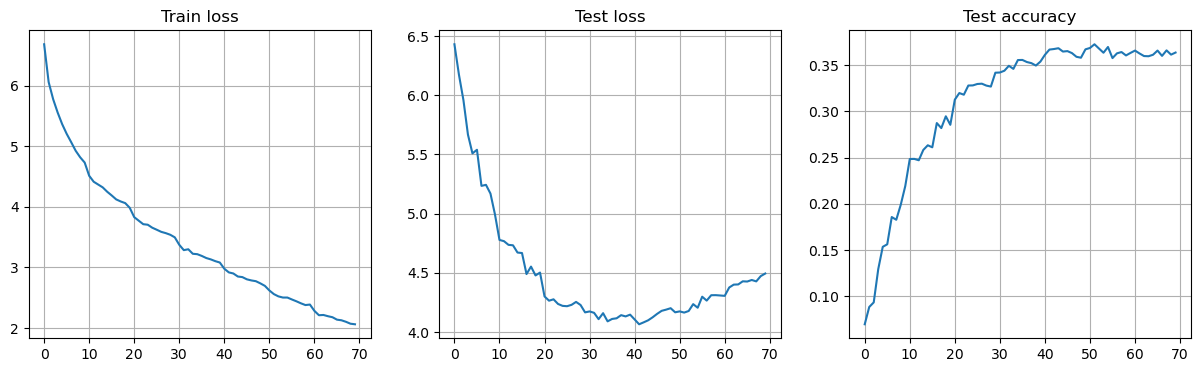

In [87]:
plot_train_func(tr_loss_hist, ts_loss_hist, ts_acc_hist)

In [17]:
k = 32

class DenseLayer(nn.Module):

    def __init__(self,in_channels):
        super(DenseLayer,self).__init__()

        self.BN1 = nn.BatchNorm2d(num_features = in_channels)
        self.conv1 = nn.Conv2d(in_channels=in_channels , out_channels=4*k , kernel_size=1 , stride=1 , padding=0 , bias = False )

        self.BN2 = nn.BatchNorm2d(num_features = 4*k)
        self.conv2 = nn.Conv2d( in_channels=4*k , out_channels=k , kernel_size=3 , stride=1 , padding=1 , bias = False )

        self.relu = nn.ReLU(inplace=True)

    def forward(self,x):
        xin = x

        # BN -> relu -> conv(1x1)
        x = self.BN1(x)
        x = self.relu(x)
        x = self.conv1(x)

        # BN -> relu -> conv(3x3)
        x = self.BN2(x)
        x = self.relu(x)
        x = self.conv2(x)

        x = torch.cat([xin,x],1)

        return x

In [18]:
class DenseBlock(nn.Module):
    def __init__(self, layer_num, in_channels):
        super(DenseBlock, self).__init__()
        self.layer_num = layer_num
        self.deep_nn = nn.ModuleList()

        for num in range(self.layer_num):
            self.deep_nn.add_module(
                f"DenseLayer_{num}", DenseLayer(in_channels + k * num)
            )

    def forward(self, x):
        for layer in self.deep_nn:
            x = layer(x)
        return x

In [19]:
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, compression_factor):
        super(TransitionLayer, self).__init__()
        self.BN = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=int(in_channels * compression_factor),
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.BN(x)
        x = self.conv1(x)
        x = self.avgpool(x)
        return x

In [53]:
compression_factor = 0.5

class DenseNet(nn.Module):
    def __init__(self, densenet_variant, in_channels, num_classes=1000):
        super(DenseNet, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=16,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False,
        )
        self.BN1 = nn.BatchNorm2d(num_features=16)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.deep_nn = nn.ModuleList()
        dense_block_inchannels = 16

        for num in range(len(densenet_variant))[:-1]:
            self.deep_nn.add_module(
                f"DenseBlock_{num+1}",
                DenseBlock(densenet_variant[num], dense_block_inchannels),
            )
            dense_block_inchannels = int(
                dense_block_inchannels + k * densenet_variant[num]
            )

            self.deep_nn.add_module(
                f"TransitionLayer_{num+1}",
                TransitionLayer(dense_block_inchannels, compression_factor),
            )
            dense_block_inchannels = int(dense_block_inchannels * compression_factor)

        self.deep_nn.add_module(
            f"DenseBlock_{num+2}",
            DenseBlock(densenet_variant[-1], dense_block_inchannels),
        )
        dense_block_inchannels = int(dense_block_inchannels + k * densenet_variant[-1])

        self.BN2 = nn.BatchNorm2d(num_features=dense_block_inchannels)

        self.average_pool = nn.AdaptiveAvgPool2d(1)

        self.fc1 = nn.Linear(dense_block_inchannels, num_classes)

    def forward(self, x):
        x = self.relu(self.BN1(self.conv1(x)))
        x = self.maxpool(x)
        for layer in self.deep_nn:
            x = layer(x)
        x = self.relu(self.BN2(x))
        x = self.average_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [54]:
model = DenseNet([3, 6, 12, 8], 3, 100).to(device)

In [55]:
summary(DenseNet([3, 6, 12, 8], 3, 100), (3, 64, 64), 500)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [500, 16, 32, 32]           2,352
       BatchNorm2d-2          [500, 16, 32, 32]              32
              ReLU-3          [500, 16, 32, 32]               0
         MaxPool2d-4          [500, 16, 16, 16]               0
       BatchNorm2d-5          [500, 16, 16, 16]              32
              ReLU-6          [500, 16, 16, 16]               0
            Conv2d-7         [500, 128, 16, 16]           2,048
       BatchNorm2d-8         [500, 128, 16, 16]             256
              ReLU-9         [500, 128, 16, 16]               0
           Conv2d-10          [500, 32, 16, 16]          36,864
       DenseLayer-11          [500, 48, 16, 16]               0
      BatchNorm2d-12          [500, 48, 16, 16]              96
             ReLU-13          [500, 48, 16, 16]               0
           Conv2d-14         [500, 128,

In [56]:
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=500, pin_memory=True, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=500, pin_memory=True, shuffle=True
)

In [57]:
tr_model, tr_loss_hist, ts_loss_hist, ts_acc_hist = train_func(train_loader, test_loader, loss_fn, acc_fn, device, 70, 3e-3, model = model)

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch: 0	train loss: 3.649285078048706	test loss:3.8532937367757163	test acc:0.09686666677395503
Epoch: 1	train loss: 3.277137279510498	test loss:3.620497298240662	test acc:0.13980000093579292
Epoch: 2	train loss: 3.145089626312256	test loss:3.3561962366104128	test acc:0.18053333312273026
Epoch: 3	train loss: 3.008303165435791	test loss:3.241374119122823	test acc:0.2037333349386851
Epoch: 4	train loss: 2.9098637104034424	test loss:3.055321764945984	test acc:0.23673333277304967
Epoch: 5	train loss: 2.871140718460083	test loss:3.004652237892151	test acc:0.24526666551828386
Epoch: 6	train loss: 2.8308603763580322	test loss:2.9729209025700887	test acc:0.24906666527191798
Epoch: 7	train loss: 2.6089062690734863	test loss:2.8550529956817625	test acc:0.27906666646401085
Epoch: 8	train loss: 2.686499834060669	test loss:2.8936996698379516	test acc:0.27053333123524986
Epoch: 9	train loss: 2.557112216949463	test loss:2.7598517974217733	test acc:0.2930000007152557
Epoch: 10	train loss: 2.477501869

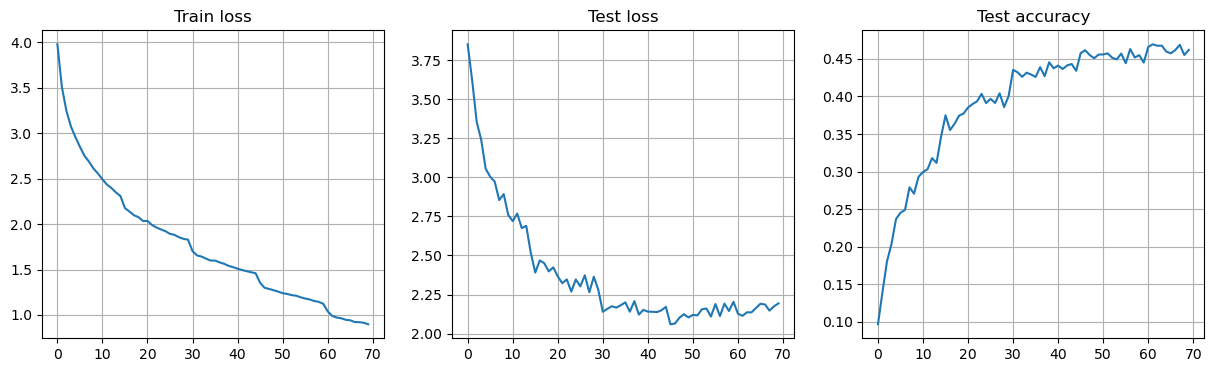

In [64]:
plot_train_func(tr_loss_hist, ts_loss_hist, ts_acc_hist)

In [58]:
class ConvBnAct(nn.Module):

    def __init__(
        self,
        n_in,
        n_out,
        kernel_size=3,
        stride=1,
        padding=0,
        groups=1,
        bn=True,
        act=True,
        bias=False,
    ):
        super(ConvBnAct, self).__init__()
        self.conv = nn.Conv2d(
            n_in,
            n_out,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            groups=groups,
            bias=bias,
        )
        self.batch_norm = nn.BatchNorm2d(n_out) if bn else nn.Identity()
        self.activation = nn.SiLU() if act else nn.Identity()

    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.activation(x)
        return x

In [59]:
class SqueezeExcitation(nn.Module):
    
    def __init__(self, n_in, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        
        
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(n_in, reduced_dim, kernel_size=1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, n_in, kernel_size=1),
            nn.Sigmoid()
        )
       
    def forward(self, x):
        y = self.se(x)
        return x * y

In [60]:
class StochasticDepth(nn.Module):
    
    def __init__(self, survival_prob = 0.8):
        super(StochasticDepth, self).__init__()
        self.p =  survival_prob
        
    def forward(self, x):
        if not self.training:
            return x
        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.p
        return torch.div(x, self.p) * binary_tensor

In [61]:
class MBConvN(nn.Module):

    def __init__(
        self,
        n_in,
        n_out,
        kernel_size=3,
        stride=1,
        expansion_factor=6,
        reduction=4,
        survival_prob=0.8,
    ):
        super(MBConvN, self).__init__()
        self.skip_connection = stride == 1 and n_in == n_out
        intermediate_channels = int(n_in * expansion_factor)
        padding = (kernel_size - 1) // 2
        reduced_dim = int(n_in // reduction)

        self.expand = (
            nn.Identity()
            if (expansion_factor == 1)
            else ConvBnAct(n_in, intermediate_channels, kernel_size=1)
        )
        self.depthwise_conv = ConvBnAct(
            intermediate_channels,
            intermediate_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            groups=intermediate_channels,
        )
        self.se = SqueezeExcitation(intermediate_channels, reduced_dim=reduced_dim)
        self.pointwise_conv = ConvBnAct(
            intermediate_channels, n_out, kernel_size=1, act=False
        )
        self.drop_layers = StochasticDepth(survival_prob=survival_prob)

    def forward(self, x):
        residual = x
        x = self.expand(x)
        x = self.depthwise_conv(x)
        x = self.se(x)
        x = self.pointwise_conv(x)

        if self.skip_connection:
            x = self.drop_layers(x)
            x += residual

        return x

In [62]:
from math import ceil

In [63]:
class EfficientNet(nn.Module):
    def __init__(self, width_mult = 1, depth_mult = 1, 
                 dropout_rate = 0.2, num_classes = 1000):
        super(EfficientNet, self).__init__()
        
        last_channel = ceil(1280 * width_mult)
        self.features = self._feature_extractor(width_mult, depth_mult, last_channel)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channel, num_classes)
        )
        
    def forward(self, x):
        
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x.view(x.shape[0], -1))
        
        return x
    
        
    def _feature_extractor(self, width_mult, depth_mult, last_channel):
        
        channels = 4 * ceil(int(32*width_mult) / 4)
        layers = [ConvBnAct(3, channels, kernel_size = 3, stride = 2, padding = 1)]
        in_channels = channels
        
        kernels = [3, 3, 5, 3, 5, 5, 3]
        expansions = [1, 6, 6, 6, 6, 6, 6]
        num_channels = [16, 24, 40, 80, 112, 192, 320]
        num_layers = [1, 2, 2, 3, 3, 4, 1]
        strides =[1, 2, 2, 2, 1, 2, 1]
        
        # Scale channels and num_layers according to width and depth multipliers.
        scaled_num_channels = [4 * ceil(int(c*width_mult) / 4) for c in num_channels]
        scaled_num_layers = [int(d * depth_mult) for d in num_layers]

        
        for i in range(len(scaled_num_channels)):
             
            layers += [MBConvN(in_channels if repeat==0 else scaled_num_channels[i], 
                               scaled_num_channels[i],
                               kernel_size = kernels[i],
                               stride = strides[i] if repeat==0 else 1, 
                               expansion_factor = expansions[i]
                              )
                       for repeat in range(scaled_num_layers[i])
                      ]
            in_channels = scaled_num_channels[i]
        
        layers.append(ConvBnAct(in_channels, last_channel, kernel_size = 1, stride = 1, padding = 0))
    
        return nn.Sequential(*layers)

In [65]:
efficient_net_config = {
    "b0" : (1.0, 1.0, 224, 0.2),
    "b1" : (1.0, 1.1, 240, 0.2),
    "b2" : (1.1, 1.2, 260, 0.3),
    "b3" : (1.2, 1.4, 300, 0.3),
    "b4" : (1.4, 1.8, 380, 0.4),
    "b5" : (1.6, 2.2, 456, 0.4),
    "b6" : (1.8, 2.6, 528, 0.5),
    "b7" : (2.0, 3.1, 600, 0.5)
}

In [85]:
width_mult, depth_mult, res, dropout_rate = efficient_net_config['b1']
model = EfficientNet(width_mult, depth_mult, dropout_rate, 100).to(device)

In [86]:
summary(EfficientNet(width_mult, depth_mult, dropout_rate, 100), (3, 64, 64), 200, 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [200, 32, 32, 32]             864
       BatchNorm2d-2          [200, 32, 32, 32]              64
              SiLU-3          [200, 32, 32, 32]               0
         ConvBnAct-4          [200, 32, 32, 32]               0
          Identity-5          [200, 32, 32, 32]               0
            Conv2d-6          [200, 32, 32, 32]             288
       BatchNorm2d-7          [200, 32, 32, 32]              64
              SiLU-8          [200, 32, 32, 32]               0
         ConvBnAct-9          [200, 32, 32, 32]               0
AdaptiveAvgPool2d-10            [200, 32, 1, 1]               0
           Conv2d-11             [200, 8, 1, 1]             264
             SiLU-12             [200, 8, 1, 1]               0
           Conv2d-13            [200, 32, 1, 1]             288
          Sigmoid-14            [200, 3

In [87]:
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=200, pin_memory=True, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=200, pin_memory=True, shuffle=True
)

In [88]:
gc.collect()

torch.mps.empty_cache()

In [89]:
def train_func(tr_l, ts_l, loss_fn, acc_fn, device, epochs=100, lr = 1e-4, model_class = None, model = None):
    if model_class == None and model == None:
        raise ValueError("Model empty")
    train_loss_hist = []
    test_loss_hist = []
    test_acc_hist = []

    

    if model == None:
        model = model_class().half().to(device)
    

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad=True, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.6)


    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = 0

        for X, y in tr_l:
            optimizer.zero_grad()

            X, y = X.to(device), y.type(torch.LongTensor).to(device)
            preds = model(X)
            
            loss = loss_fn(preds, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        
        scheduler.step()
        train_loss /= len(tr_l)
        train_loss_hist.append(train_loss)


        model.eval()
        test_loss = 0
        test_acc = 0

        

        with torch.no_grad():
            for X, y in ts_l:
                X, y = X.to(device), y.type(torch.LongTensor).to(device)
                preds = model(X)
                test_loss += loss_fn(preds, y).item()
                test_acc += acc_fn(y, torch.argmax(preds, dim=1)).item()

        

        test_loss /= len(ts_l)
        test_acc /= len(ts_l)
        test_loss_hist.append(test_loss)
        test_acc_hist.append(test_acc)

        print(
            f"Epoch: {epoch}\ttrain loss: {loss}\ttest loss:{test_loss}\ttest acc:{test_acc}"
        )
        
    return (model, train_loss_hist, test_loss_hist, test_acc_hist)

In [90]:
tr_model, tr_loss_hist, ts_loss_hist, ts_acc_hist = train_func(train_loader, test_loader, loss_fn, acc_fn, device, 50, 3e-3, model = model)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0	train loss: 4.2701921463012695	test loss:4.333324324289958	test acc:0.0331333331267039
Epoch: 1	train loss: 3.9317071437835693	test loss:4.084389979044596	test acc:0.06333333323399226


KeyboardInterrupt: 